<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изменение-баланса-классов" data-toc-modified-id="Изменение-баланса-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изменение баланса классов</a></span><ul class="toc-item"><li><span><a href="#Изменение-весов-классов" data-toc-modified-id="Изменение-весов-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Изменение весов классов</a></span></li><li><span><a href="#Ресемплирование-с-уменьшением-класса-0" data-toc-modified-id="Ресемплирование-с-уменьшением-класса-0-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Ресемплирование с уменьшением класса 0</a></span></li></ul></li><li><span><a href="#Вывод-по-шагу-1" data-toc-modified-id="Вывод-по-шагу-1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод по шагу 1</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-SGDClassifier" data-toc-modified-id="Классификатор-SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор SGDClassifier</a></span></li><li><span><a href="#Вывод-по-шагу-2" data-toc-modified-id="Вывод-по-шагу-2-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод по шагу 2</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></li></div>

<div style="border:2px solid Black; padding:20px;">

#Проект для "Викишоп"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

</div>

## Подготовка

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
toxic_comments = pd.read_csv('datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
display(toxic_comments['toxic'].value_counts())
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Классы несбалансированы. Отношение 1:8.84. Проведем поиск лучшего способа балансировки и сравним качество.

1. Изменение весов в модели обучения
2. Ресемплирование с уменьшением класса 0

Ресемплирование с увеличением класса 1 не будем использовать из-за громоздкого набора данных.

Подготовим признаки и целевой признак перед обучением.

In [ ]:
%%time

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }
    return tag_dict.get(tag, wordnet.NOUN)



def lemmatize_text(text):

    m = WordNetLemmatizer()

    lemm_list = [m.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    lemm_text = " ".join(lemm_list)

    return lemm_text

def clear_text(text):

    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())


toxic_comments['lemm_text']= toxic_comments['text'].apply(lambda x: lemmatize_text(clear_text(x)))

toxic_comments.head()

CPU times: user 22min 3s, sys: 1min 35s, total: 23min 39s
Wall time: 24min 17s


,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


Разобьем выборку по отношению 60/20/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.

In [ ]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.4,
                                                                              random_state=12082020)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12082020)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values)
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values)
features_test = count_tf_idf.transform(features_test['lemm_text'].values)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

(95575, 117958)
(31858, 117958)
(31859, 117958)


In [ ]:
%%time

classificator = LogisticRegression(random_state = 12345)
train_f1 = cross_val_score(classificator,
                      features_train,
                      target_train,
                      cv=cv_counts,
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6800956984664874
CPU times: user 13.3 s, sys: 15.4 s, total: 28.7 s
Wall time: 16.5 s


### Изменение баланса классов

#### Изменение весов классов

In [ ]:
%%time

dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes, random_state = 12345)
train_f1_ballanced = cross_val_score(classificator,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7481004418846742
CPU times: user 16.5 s, sys: 19.8 s, total: 36.2 s
Wall time: 21.6 s


In [ ]:
%%time

classificator = LogisticRegression(class_weight='balanced', random_state = 12345)
train_f1_balanced = cross_val_score(classificator,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7481004418846742
CPU times: user 9.71 s, sys: 11.1 s, total: 20.8 s
Wall time: 12.3 s


Как видно на обучающей выборке F1-мера увеличилась. Встроенный метод повторяет значение F1.

#### Ресемплирование с уменьшением класса 0

Сделаем количество записей с классом 0 таким же, как и количество записей с классом 1.

In [ ]:
toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [ ]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))
del count_tf_idf
del stopwords

In [ ]:
classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample,
                      target_train_downsample,
                      cv=cv_counts,
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8820067126091634


Прирост F1-меры ощутимый.

Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

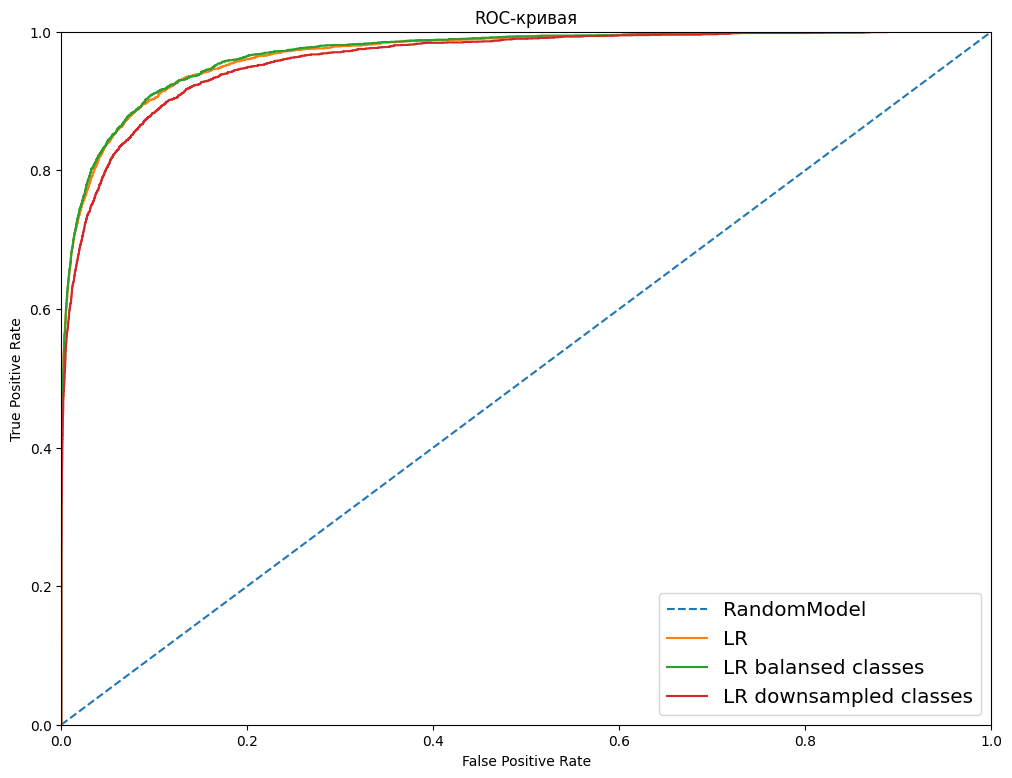

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression(random_state = 12345)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes, random_state = 12345)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR balansed classes')

classificator = LogisticRegression(random_state = 12345)
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [ ]:
index = ['LogisticRegression',
         'LR balansed classes',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.680096,0.719011,0.967503
LR balansed classes,0.740004,0.741869,0.968922
LR downsampled classes,0.882007,0.674083,0.960124


Выберем метод балансировки по весу. Удалим ненужные переменные.

In [ ]:
del toxic_comments_train
del target_train_class_zero
del target_train_class_one
del target_train_class_zero_downsample
del target_train_downsample
del features_train_downsample

### Вывод по шагу 1

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

## Обучение

Для обучения выберем следующие модели:

1. LogisticRegression
2. DecisionTreeClassifier
3. CatBoostClassifier
4. SGDClassifier

### Классификатор LogisticRegression

In [ ]:
%%time

classificator = LogisticRegression(random_state = 12345)
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}

Grid scores on development set:

0.705859 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.705917 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.705942 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.747925 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.748100 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.747890 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.754327 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.755008 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.754289 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': '

In [ ]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7550084981725297
F1 на валидации 0.7538439010103968
CPU times: user 7.68 s, sys: 9.04 s, total: 16.7 s
Wall time: 11.7 s


### Классификатор DecisionTreeClassifier

In [ ]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 48, 'random_state': 12082020}

Grid scores on development set:

0.604490 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 30, 'random_state': 12082020}
0.608706 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 32, 'random_state': 12082020}
0.615073 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 34, 'random_state': 12082020}
0.592718 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 36, 'random_state': 12082020}
0.599792 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 38, 'random_state': 12082020}
0.601229 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 40, 'random_state': 12082020}
0.609520 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 42, 'random_state': 12082020}
0.614677 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_dep

In [ ]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6157551844077654
F1 на валидации 0.608945300695074
CPU times: user 39.1 s, sys: 40.7 ms, total: 39.2 s
Wall time: 39.2 s


### Классификатор SGDClassifier

In [ ]:
%%time

classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12082020}

Grid scores on development set:

0.731894 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 12082020}
0.714827 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 12082020}
0.746699 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 12082020}
0.732846 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 12082020}
0.716338 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 12082020}
0.74

In [ ]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7513798716940142
F1 на валидации 0.7459444597195491
CPU times: user 2.12 s, sys: 97.2 ms, total: 2.22 s
Wall time: 2.18 s


Выведем таблицу валидации лучших моделей.

In [ ]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_SGDC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.755008,0.753844,True
DecisionTreeClassifier,0.615755,0.608945,False
SGDClassifier,0.751380,0.745944,False


### Вывод по шагу 2

К тестовому набору данных перейдут LogisticRegression и SGDClassifier.

## Выводы

Проведем получение F1-меры, precision, recall, accuracy и roc_auc. Так же построим графики.

Метрики LogisticRegression
ROC AUC: 0.9632993566342172
F1: 0.762450418686646
Precision: 0.7216351501668521
Recall: 0.8081594518841483
Accuracy: 0.9492451112715402

Метрики SGDClassifier
ROC AUC: 0.9688392636541294
F1: 0.7530744783750173
Precision: 0.6768504719324392
Recall: 0.8486452818436624
Accuracy: 0.9439090994695376



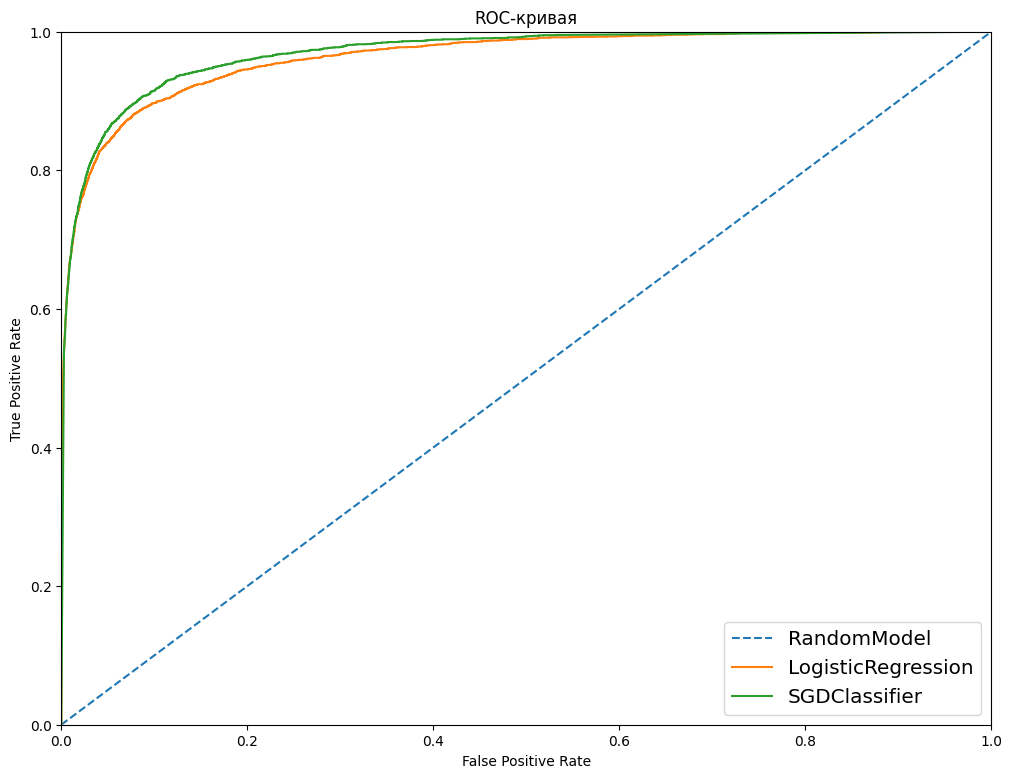

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()